# Plan sites for Canopy Height Modelling to study shrub changes in western AK
Identify candidate sites where we'll apply CNN workflow to SRLite strips trained with wither GLiHT or IFSar

Intersect GLiHT footprints with SRLite footprints, then intersect with LVIS footprints to identidy candidate validation sites

In [2]:
import geopandas as gpd
import pandas as pd
import os, sys
sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import matplotlib.pyplot as plt
import contextily as ctx
import re
import fiona

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_3751810/3446805488.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
MAINDIR = '/explore/nobackup/people/pmontesa/userfs02/arc/_footprints'
OUTDIR = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs'

In [4]:
# Open the LVIS file, which has multiple layers based on year
foot_lvis_fn = os.path.join(MAINDIR, 'footprints_lvis_above.gpkg')
gdf_list = []
for layername in fiona.listlayers(foot_lvis_fn):
    gdf_list.append(gpd.read_file(foot_lvis_fn, layer=layername))
foot_lvis = pd.concat(gdf_list, ignore_index=True).to_crs(4326)
foot_lvis.columns = [x.lower() for x in foot_lvis.columns]

In [5]:
foot_lvis['sensor'] = 'LVIS'

In [6]:
foot_gliht =   gpd.read_file(os.path.join(MAINDIR, 'footprints_gliht_13m_p50.gpkg'))
#foot_lvis =    gpd.read_file(os.path.join(MAINDIR, 'footprints_lvis_above.gpkg')).to_crs(4326)
foot_srlite =  gpd.read_file('/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_SR_alaska.gpkg').to_crs(4326)

In [7]:
foot_gliht['sensor'] = 'GLiHT'

## Get year of each flightline

In [8]:
foot_gliht['year'] = foot_gliht['file'].apply(lambda x: int(str([int(s) for s in re.findall(r'[\d]*[''][\d]+' , x) if int(s) > 2000][0])[0:4]))
foot_lvis['year']  = foot_lvis['file'].apply(lambda x: int(str([int(s) for s in re.findall(r'[\d]*[''][\d]+' , x) if int(s) > 2000][0])[0:4]))

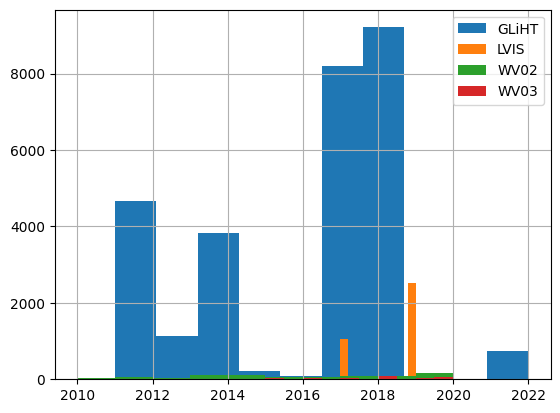

In [12]:
from matplotlib.ticker import MaxNLocator
cols = ['year', 'sensor']

ax = pd.concat([foot_gliht[cols], foot_lvis[cols], foot_srlite[cols]]).groupby('sensor').year.hist(legend=True)

In [13]:
foot_list = list(reversed([foot_gliht, foot_lvis, foot_srlite]))

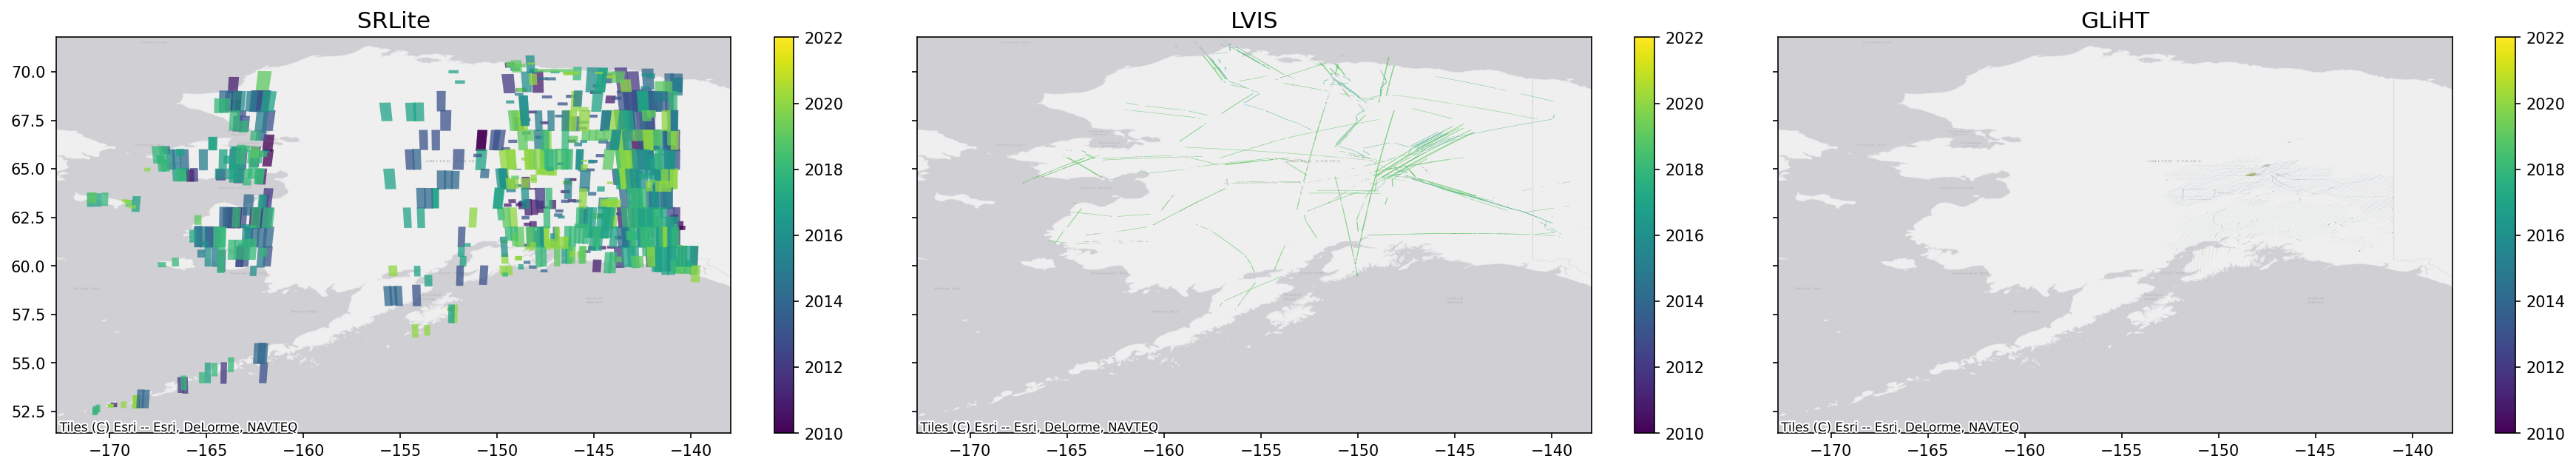

In [15]:
import importlib
importlib.reload(footprintlib)

fig, axa = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, dpi=150, figsize=(24,4))

type_name_list  = list(reversed(['GLiHT', 'LVIS', 'SRLite']))

for n, ax in enumerate(axa.ravel()):
    # This makes leftover axes empty and doesnt return an error
    if n >= len(foot_list):
        ax.axis('off')
        pass
    else:
        ax.set_title(type_name_list[n], fontsize=15)
        ax = footprintlib.MAP_FOOTPRINTS(foot_list[n].cx[-171:-140,50:75], 'year', ax=ax, CMAP='viridis', CAT=False, VMIN=2010, VMAX=2022)

plt.tight_layout()


# Get intersection of SRLite with GLiHT and LVIS
this will tell us from where we can assemble tiles from both IFSAR and GLiHT and where we can then validate with LVIS

In [16]:
foot_intersect_srlite_gliht = gpd.overlay(foot_srlite, foot_gliht, how='intersection')
foot_intersect_srlite_gliht_lvis = gpd.overlay(foot_intersect_srlite_gliht, foot_lvis, how='intersection')

## Here are our candidate model training sites

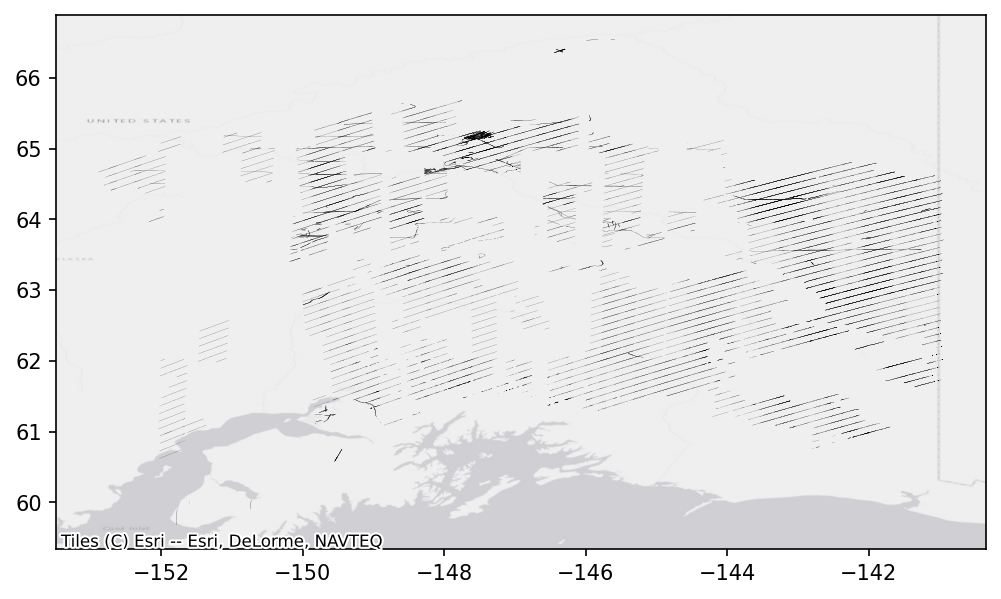

In [277]:
f, ax = plt.subplots(nrows=1, ncols=1,dpi=150, figsize=(8,8)) 

ax = foot_intersect_srlite_gliht.plot(ax=ax, color='black')
ax = ctx.add_basemap(ax, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

## Here are our candidate validation sites

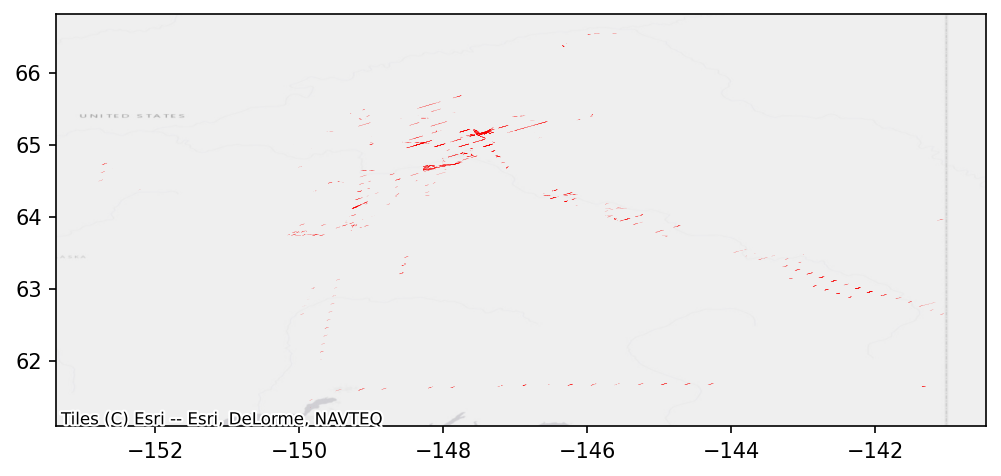

In [276]:
f, ax = plt.subplots(nrows=1, ncols=1,dpi=150, figsize=(8,8)) 

#ax = foot_intersect_srlite_gliht.plot(ax=ax, color='black')
ax = foot_intersect_srlite_gliht_lvis.plot(ax=ax, color='red')
ax = ctx.add_basemap(ax, crs=4326, 
            source = ctx.providers.Esri.WorldGrayCanvas
        )

In [273]:
foot_intersect_srlite_gliht.to_file(os.path.join(OUTDIR, 'footprints_intersect_srlite_gliht.gpkg'), driver = 'GPKG')
foot_intersect_srlite_gliht_lvis.to_file(os.path.join(OUTDIR, 'footprints_intersect_srlite_gliht_lvis.gpkg'), driver = 'GPKG')

## We need to acquire the CHMs and DTMs for these GLiHT flightlines

In [20]:
gliht_flightlines_to_acquire = [x.split('_all')[0] for x in list(set(foot_intersect_srlite_gliht.file_2.to_list()))]

gliht_flightlines_to_acquire[0:10]

['AK_20140712_DoD1_l3s544',
 'AK_20140714_TIU_l3s26',
 'AK_20140715_l1s716',
 'AK_20140712_DoD2_l7s4',
 'AK_20140713_l3s695',
 'AK_11Jul2014_l5s630',
 'AK_20180731_JBER_1_l0s4',
 'AK_20180728_FIA_10_l0s199',
 'AK_10Jul2014_l0s570',
 'AK_20180721_FIA_34_l0s89']

In [292]:
len(gliht_flightlines_to_acquire)

8229

### Download the GLiHT CHMs and DTMs for the flightlines

##### For 2 TYPES: 'CHM' and 'DTM'
```  

TYPE_LIST='CHM DTM'  

for TYPE in TYPE_LIST; do

for i in $(cat file);do k=https://glihtdata.gsfc.nasa.gov/files/G-LiHT/${i}/lidar/geotiff/${i}_${TYPE}.tar.gz;echo $k >> new_file  

    wget --input-file="new_file"  
```
    

## Footprint IFSAR to analyze year of tiles

In [ ]:
DIR_IFSAR = '/explore/nobackup/projects/dem/AK_IFSAR/raw/dsm' # matt needs to open perms on the subdirs here

In [ ]:
f_list_ifsar = glob.glob(f"{DIR_IFSAR}/**/*.tif", recursive=True)

# Make footprint gdfs of the the filenames, concat to single gdf
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_ifsar]
footprint_gdf_ifsar = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
